# Preparations

## Variables

### Logging

In [1]:
ENABLE_PRINT = True
ENABLE_WANDB_LOG = True

train_step = 0
val_step = 0

### Device

In [2]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## Utils

### Label-color correlator

In [7]:
from abc import ABCMeta
from dataclasses import dataclass
from typing import Tuple

@dataclass
class GTA5Label:
    name: str
    ID: int
    color: Tuple[int, int, int]

class GTA5Labels_TaskCV2017():
    road = GTA5Label(name = "road", ID=0, color=(128, 64, 128))
    sidewalk = GTA5Label(name = "sidewalk", ID=1, color=(244, 35, 232))
    building = GTA5Label(name = "building", ID=2, color=(70, 70, 70))
    wall = GTA5Label(name = "wall", ID=3, color=(102, 102, 156))
    fence = GTA5Label(name = "fence", ID=4, color=(190, 153, 153))
    pole = GTA5Label(name = "pole", ID=5, color=(153, 153, 153))
    light = GTA5Label(name = "light", ID=6, color=(250, 170, 30))
    sign = GTA5Label(name = "sign", ID=7, color=(220, 220, 0))
    vegetation = GTA5Label(name = "vegetation", ID=8, color=(107, 142, 35))
    terrain = GTA5Label(name = "terrain", ID=9, color=(152, 251, 152))
    sky = GTA5Label(name = "sky", ID=10, color=(70, 130, 180))
    person = GTA5Label(name = "person", ID=11, color=(220, 20, 60))
    rider = GTA5Label(name = "rider", ID=12, color=(255, 0, 0))
    car = GTA5Label(name = "car", ID=13, color=(0, 0, 142))
    truck = GTA5Label(name = "truck", ID=14, color=(0, 0, 70))
    bus = GTA5Label(name = "bus", ID=15, color=(0, 60, 100))
    train = GTA5Label(name = "train", ID=16, color=(0, 80, 100))
    motocycle = GTA5Label(name = "motocycle", ID=17, color=(0, 0, 230))
    bicycle = GTA5Label(name = "bicycle", ID=18, color=(119, 11, 32))
    void = GTA5Label(name = "void", ID=255, color=(0,0,0))

    list_ = [
        road,
        sidewalk,
        building,
        wall,
        fence,
        pole,
        light,
        sign,
        vegetation,
        terrain,
        sky,
        person,
        rider,
        car,
        truck,
        bus,
        train,
        motocycle,
        bicycle,
        void
    ]

### Functions

In [ ]:
import numpy as np
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from tqdm.notebook import tqdm

def pretty_extract(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        png_files = [f for f in zip_ref.namelist() if f.endswith('.png')]

        for file in tqdm(png_files, desc="Extracting PNGs"):
            zip_ref.extract(file, path=extract_to)

def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

# Mapping labelId image to RGB image
def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label_id in GTA5Labels_TaskCV2017().list_:
        color_mask[mask == label_id.ID, :] = label_id.color

    return color_mask

def tensorToImageCompatible(tensor):
    """
    convert from a tensor of shape [C, H, W] where a normalization has been applied
    to an unnormalized tensor of shape [H, W, C],
    so *plt.imshow(tensorToImageCompatible(tensor))* works as expected.\n
    Intended to be used to recover the original element
    when CityScapes dataset apply the transformation
    - transform = TF.Compose([
        TF.ToTensor(),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])])
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return np.round(255*(tensor * std[:, None, None] + mean[:, None, None]).permute(1,2,0).numpy(), 0).astype(np.uint8)


def log_confusion_matrix(title:str, hist:np.ndarray, tag:str, step_name:str, step_value):

    row_sums = hist.sum(axis=1, keepdims=True)
    safe_hist = np.where(row_sums == 0, 0, hist / row_sums)

    plt.figure(figsize=(10, 8))
    sns.heatmap(100.*safe_hist, fmt=".2f", annot=True, cmap="Blues", annot_kws={'size': 7})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)

    wandb.log({tag: wandb.Image(plt), step_name:step_value}, commit=True)
    plt.close()


## CityScapes download

In [ ]:
# !pip install -q gdown

# file_id = "1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O"
# !gdown https://drive.google.com/uc?id={file_id}

# pretty_extract("Cityscapes.zip", ".")


Downloading...
From (original): https://drive.google.com/uc?id=1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O
From (redirected): https://drive.google.com/uc?id=1MI8QsvjW0R6WDJiL49L7sDGpPWYAQB6O&confirm=t&uuid=593db36f-5ca0-4f3e-815a-5204b0840f6f
To: /content/Cityscapes.zip
100% 4.97G/4.97G [00:54<00:00, 92.1MB/s]


Extracting PNGs:   0%|          | 0/6216 [00:00<?, ?it/s]

## GTA5 download

In [4]:
# !pip install -q gdown

# file_id = "1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE"
# !gdown https://drive.google.com/uc?id={file_id}

# # !unzip Gta5_extended.zip -d ./Gta5_extended

# pretty_extract("Gta5_extended.zip", "./Gta5_extended")

Downloading...
From (original): https://drive.google.com/uc?id=1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE
From (redirected): https://drive.google.com/uc?id=1PWavqXDxuifsyYvs2PFua9sdMl0JG8AE&confirm=t&uuid=840fb1b4-9b24-40af-9803-5fd503e1df42
To: /content/Gta5_extended.zip
100% 6.28G/6.28G [01:23<00:00, 75.3MB/s]


Extracting PNGs:   0%|          | 0/7500 [00:00<?, ?it/s]

## Metrics understanding

per_class_iou:
[31.5504744  26.7521346  26.2414254  28.76638419 31.33793475 28.79775786
 28.98861555 30.01514917 26.71018598 34.32470973 32.68351276 28.75460328
 38.13832902 32.00819154 30.06410015 29.93726155 28.35613348 32.09941569
 31.69018963 35.50356842]
mIoU:30.636003857708506


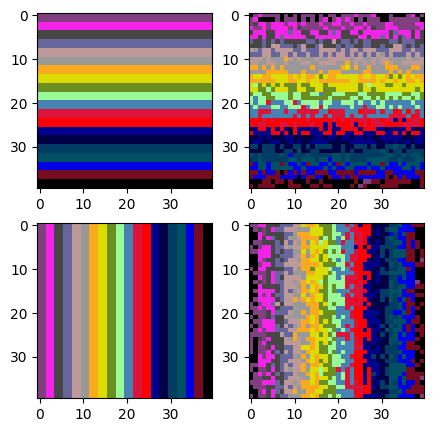

In [11]:
def test_metrics():
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    B = 2
    H = 40
    W = 40
    n_classes = 20

    target = torch.randint(0, n_classes, (B, H, W), dtype=torch.int64)

    step = H//n_classes
    for i in range(n_classes):
        target[0, i*step:(i+1)*step, :] = i

    step = W//n_classes
    for i in range(n_classes):
        target[1, :, i*step:(i+1)*step] = i

    noise = torch.randint(-10, 11, (B, H, W), dtype=torch.int64)//10
    pred = (target + noise)% n_classes

    iou_class = np.zeros(n_classes)
    for i in range(B):
        iou_class += 100.*per_class_iou(fast_hist(target[i].numpy(), pred[i].numpy(), n_classes))

    print(f"per_class_iou:\n{iou_class/B}")
    print(f"mIoU:{iou_class[iou_class > 0].mean()/B}")

    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs[0, 0].imshow(decode_segmap(target[0]))
    axs[0, 1].imshow(decode_segmap(pred[0]))

    axs[1,0].imshow(decode_segmap(target[1]))
    axs[1,1].imshow(decode_segmap(pred[1]))

test_metrics()

## Cityscapes implementation

In [ ]:
from torch.utils.data import Dataset
import numpy as np

import os
import cv2
from PIL import Image

class CityScapes(Dataset):
    def __init__(self, rootdir, split="train", targetdir="gtFine", imgdir="images", transform=None, target_transform=None):
        super(CityScapes, self).__init__()

        self.rootdir = rootdir
        self.split = split
        self.targetdir = os.path.join(self.rootdir, targetdir, self.split) # ./gtFine/train/
        self.imgdir = os.path.join(self.rootdir, imgdir, self.split) # ./images/train/
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for city in os.listdir(self.imgdir): # frankfurt
            img_city_dir = os.path.join(self.imgdir, city) # ./images/train/frankfurt/
            target_city_dir = os.path.join(self.targetdir, city) # ./gtFine/train/frankfurt/

            for img_path in os.listdir(img_city_dir): # frankfurt_000000_000294_leftImg8bit.png
                if img_path.endswith(".png"):
                  self.imgs_path.append(os.path.join(img_city_dir, img_path)) # ./images/train/frankfurt/frankfurt_000000_000294_leftImg8bit.png

                  target_color_path = img_path.replace("leftImg8bit", "gtFine_color") # frankfurt_000000_000294_gtFine_color.png
                  target_labelIds_path = img_path.replace("leftImg8bit", "gtFine_labelTrainIds") # frankfurt_000000_000294_gtFine_labelTrainIds.png

                  self.targets_color_path.append(os.path.join(target_city_dir, target_color_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_color.png
                  self.targets_labelIds_path.append(os.path.join(target_city_dir, target_labelIds_path)) # ./gtFine/train/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')

        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')

        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED).astype(np.long)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)


## GTA5 implementation

### Dataset

In [ ]:
from torch.utils.data import Dataset
import numpy as np

import os
import cv2
from PIL import Image

from tqdm import tqdm
import random

class GTA5(Dataset):
    def __init__(self, rootdir, file_names, imgdir="images", targetdir="labels",  transform=None, target_transform=None):
        super(GTA5, self).__init__()

        self.rootdir = rootdir

        self.targetdir = os.path.join(self.rootdir, targetdir) # ./labels
        self.imgdir = os.path.join(self.rootdir, imgdir) # ./images
        self.transform = transform
        self.target_transform = target_transform

        self.imgs_path = []
        self.targets_color_path = []
        self.targets_labelIds_path = []

        for image_file in file_names: # 00001.png
            self.imgs_path.append(os.path.join(self.imgdir, image_file)) #./images/00001.png

            target_color_path = image_file # 00001.png
            target_labelsId_path = image_file.split(".")[0]+"_labelIds.png" # labelIds_00001.png

            self.targets_color_path.append(os.path.join(self.targetdir, target_color_path)) #./labels/00001.png
            self.targets_labelIds_path.append(os.path.join(self.targetdir, target_labelsId_path)) #./labels/labelIDs_00001.png

    def create_target_img(self):
        list_ = GTA5Labels_TaskCV2017().list_

        for i, img_path in tqdm(enumerate(self.targets_color_path)):
            image_numpy = np.asarray(Image.open(img_path).convert('RGB'))

            H, W, _ = image_numpy.shape
            label_image = 255*np.ones((H, W), dtype=np.uint8)

            for label in list_:
                label_image[(image_numpy == label.color).all(axis=-1)] = label.ID

            new_img = Image.fromarray(label_image)
            new_img.save(self.targets_labelIds_path[i])

    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx]).convert('RGB')

        target_color = Image.open(self.targets_color_path[idx]).convert('RGB')
        target_labelIds = cv2.imread(self.targets_labelIds_path[idx], cv2.IMREAD_UNCHANGED).astype(np.long)

        if self.transform is not None:
            image = self.transform(image)
            target_color = self.transform(target_color)
        if self.target_transform is not None:
            target_labelIds = self.target_transform(target_labelIds)

        return image, target_color, target_labelIds

    def __len__(self):
        return len(self.imgs_path)

def GTA5_dataset_splitter(rootdir, train_split_percent, split_seed = None, imgdir="images", targetdir="labels", transform=None, target_transform=None):
    img_path = os.path.join(rootdir, imgdir) # ./images

    file_names = [f for f in os.listdir(img_path) if f.endswith(".png")]

    if split_seed is not None:
        random.seed(split_seed)
    random.shuffle(file_names)

    split_idx = int(len(file_names) * train_split_percent)

    train_files = file_names[:split_idx]
    val_files = file_names[split_idx:]

    return GTA5(rootdir, train_files, imgdir, targetdir, transform, target_transform), \
           GTA5(rootdir, val_files, imgdir, targetdir, transform, target_transform)


## Dataset utilization

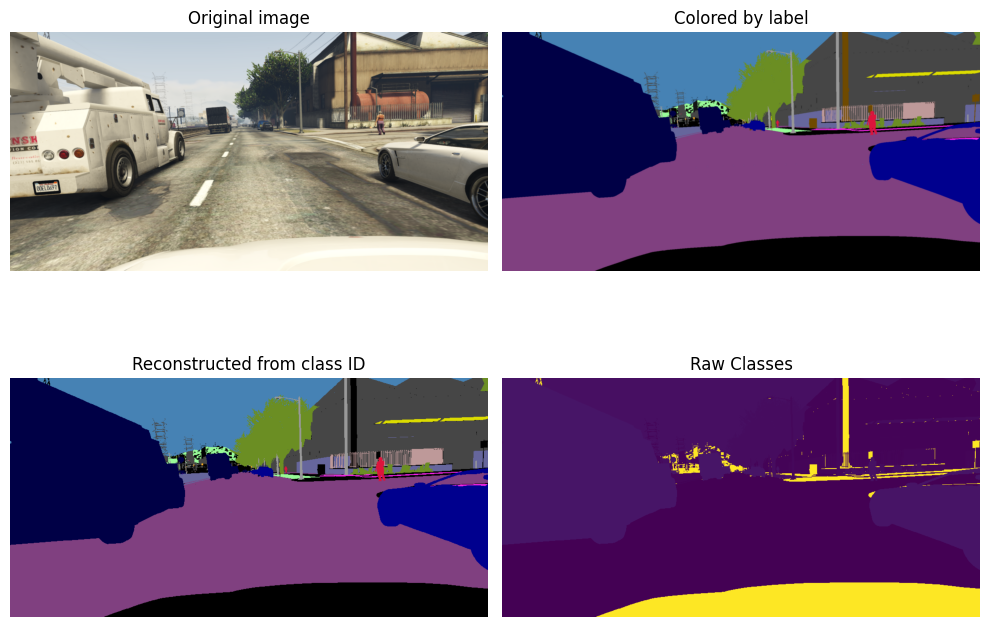

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as TF

import matplotlib.pyplot as plt

def test_dataset():
    B = 3
    H = 512
    W = 1024
    dataset = "GTA5"

    transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H,W)),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    target_transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
    ])

    if dataset == "Cityscapes":
        data = CityScapes("./Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
    elif dataset == "GTA5":
        data, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=0.6, split_seed=42, transform=transform, target_transform=target_transform)
    else:
        raise Exception("Wrong dataset name")

    dataloader = DataLoader(data, batch_size=B, shuffle=True)
    i = 0
    img_tensor, color_tensor, label = next(iter(dataloader))

    img = tensorToImageCompatible(img_tensor[i])
    color = tensorToImageCompatible(color_tensor[i])
    decoded_from_labelId = decode_segmap(label[i, 0])

    fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

    ax[0,0].set_title("Original image")
    ax[0,0].imshow(np.round(255*img, 0).astype(np.uint8))
    ax[0,0].axis('off')

    ax[0,1].set_title("Colored by label")
    ax[0,1].imshow(color)
    ax[0,1].axis('off')

    ax[1,0].set_title("Reconstructed from class ID")
    ax[1,0].imshow(decoded_from_labelId)
    ax[1,0].axis('off')

    ax[1,1].set_title("Raw Classes")
    ax[1,1].imshow(label[i, 0])
    ax[1,1].axis('off')

    fig.show()

test_dataset()

## Bisenet

In [109]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torchvision import models

class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result


## Wandb

In [ ]:
!pip -q install wandb

loss,▆▃▆▃▁▇▃▂█▄
mIou,▄▆▃▁█▁▄▄▁▇
loss,8.95217
mIou,6.55022


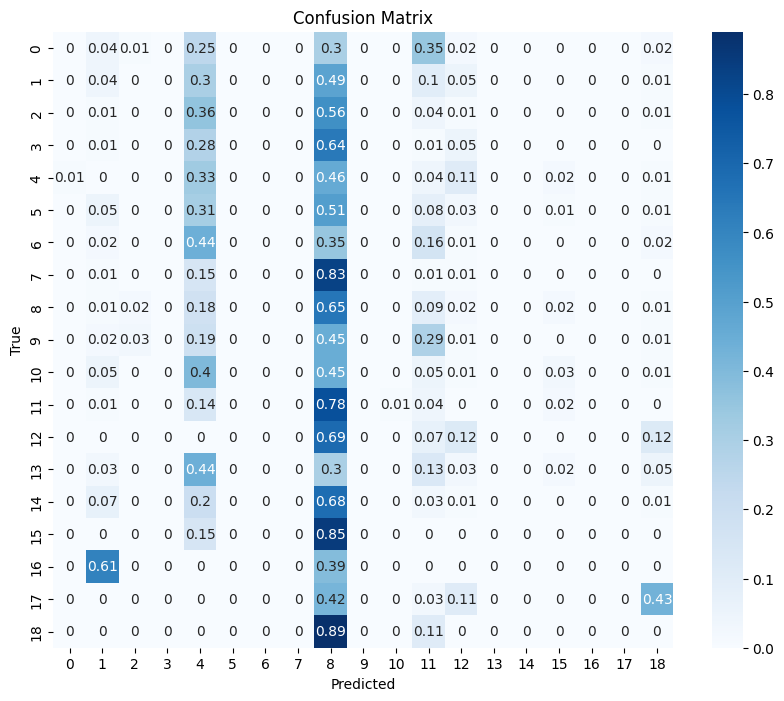

loss,▃▃▃▃▆▁█▂▇▅
mIou,▁▂▁▃▂▁▃█▃▃
loss,6.26717
mIou,3.88723


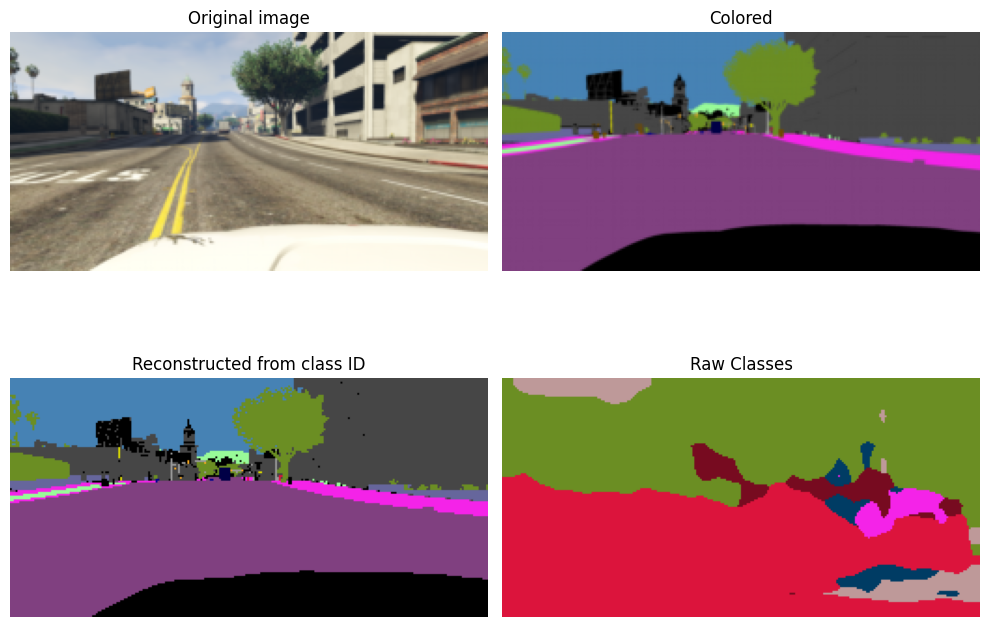

In [ ]:
def test_the_run():
    import wandb

    from torch.utils.data import DataLoader
    import torchvision.transforms as TF

    import numpy as np

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set the context of the run
    B = 4
    H = 128
    W = 256
    n_classes = 19

    context_path = "resnet18"
    epochs = 2
    lr=0.0001
    momentum=0.9
    weight_decay=5e-4
    dataset = "GTA5"

    transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H,W)),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    target_transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
    ])

    # Choose the dataset
    if dataset == "Cityscapes":
        data = CityScapes("/content/Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
    elif dataset == "GTA5":
        data, _ = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=0.6, split_seed=42, transform=transform, target_transform=target_transform)
    else:
        raise Exception("Wrong dataset name")

    dataloader = DataLoader(data, batch_size=B, shuffle=True)

    model = BiSeNet(n_classes, context_path).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Start a new wandb run to track this script.
    run = wandb.init(
        # Set the wandb entity where your project will be logged (generally your team name).
        entity="Machine_learning_and_Deep_learning_labs",
        # Set the wandb project where this run will be logged.
        project="Semantic Segmentation",
        name=f"BiSeNet-{context_path}",
        tags=[f"step2"],
        # Track hyperparameters and run metadata.
        config={
            "learning_rate": lr,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "architecture": f"BiSeNet-{context_path}",
            "dataset": dataset,
            "epochs": epochs,
            "batch": B
        },
    )

    # Body of the run (here simulation of validation step)
    model.eval()

    running_hist = np.zeros((n_classes,n_classes))
    for i in range(epochs):
        running_loss = 0.0

        # We are considering only one batch of the epoch just for visualization purpose
        inputs, colors, targets = next(iter(dataloader))
        inputs = inputs.to(device)
        targets = targets.squeeze().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        predicted = outputs.argmax(1)

        hist_batch = np.zeros((n_classes, n_classes))
        for i in range(len(inputs)):
            hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

        running_loss = loss.item()
        running_hist += hist_batch
        mIou = per_class_iou(hist_batch)

        run.log({"loss": running_loss, "mIou": 100*mIou[mIou > 0].mean()})


    # After your loop ends:
    row_sums = running_hist.sum(axis=1, keepdims=True)
    safe_hist = np.where(row_sums == 0, 0, running_hist / row_sums)

    plt.figure(figsize=(10, 8))
    sns.heatmap(np.round(safe_hist, 2), annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Log the matplotlib figure as an image
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()


    t = 0
    img_tensor, color_tensor, label = next(iter(dataloader))

    out = model(img_tensor.to(device)).argmax(1).cpu()

    img = tensorToImageCompatible(img_tensor[t])
    color = tensorToImageCompatible(color_tensor[t])
    decoded_from_labelId = decode_segmap(label[t, 0])
    out_decoded = decode_segmap(out[t])

    fig, ax = plt.subplots(2,2, figsize=(10,10), layout="tight")

    ax[0,0].set_title("Original image")
    ax[0,0].imshow(img)
    ax[0,0].axis('off')

    ax[0,1].set_title("Colored")
    ax[0,1].imshow(color)
    ax[0,1].axis('off')

    ax[1,0].set_title("Reconstructed from class ID")
    ax[1,0].imshow(decoded_from_labelId)
    ax[1,0].axis('off')

    ax[1,1].set_title("Raw Classes")
    ax[1,1].imshow(out_decoded)
    ax[1,1].axis('off')

    fig.show()

    # How to save the model weights to wandb

    # weights_path = f"{run.dir}/weights_epoch{i}.pth"
    # torch.save(model.state_dict(), weights_path)

    # # TODO: add artifact version
    # artifact = wandb.Artifact(name=f"BiseNet-{context_path}", type="model")
    # artifact.add_file(weights_path)

    # run.log_artifact(artifact)

    # End the run
    run.finish()

# test_the_run()

# Train/Val loops

### Train Loop

In [110]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import wandb

# TODO: maybe last class (void) converted to n_classes-1 due to argmax
# TODO: do i only upload avg of last N batches or all, since different B produce different num_batch
def train(epoch:int, model:nn.Module, train_loader:DataLoader, criterion:nn.Module, optimizer:optim.Optimizer) -> tuple[float, float, np.ndarray]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step

    model.train()
    train_loss = 0.0
    train_hist = np.zeros((n_classes,n_classes))

    num_batch = len(train_loader)
    num_sample = len(train_loader.dataset)

    for batch_idx, (inputs, _, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.squeeze().to(device)

        outputs, cx1_sup, cx2_sup = model(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(1)

        hist_batch = np.zeros((n_classes, n_classes))
        for i in range(len(inputs)):
            hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

        train_loss += loss.item()
        train_hist += hist_batch
        iou_batch = per_class_iou(hist_batch)

        if ENABLE_PRINT:
            if (batch_idx % (num_batch//10+1)) == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{num_sample} ({100. * batch_idx*len(inputs) / num_sample:.0f}%)]')
                print(f'\tLoss: {loss.item():.6f}')
                print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

        if ENABLE_WANDB_LOG:
            wandb.log({
                    "train/step": train_step,
                    "train/batch_loss": loss.item(),
                    "train/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                },
                commit=True,
            )

        train_step += 1

    train_loss = train_loss / num_batch

    train_iou_class = per_class_iou(train_hist)
    train_mIou = train_iou_class[train_iou_class > 0].mean()

    return train_loss, train_mIou, train_hist


### Validation loop

In [111]:
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

def validate(epoch:int, model:nn.Module, val_loader:DataLoader, criterion:nn.Module) -> tuple[float, float, np.ndarray]:
    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global val_step

    model.eval()
    val_loss = 0.0
    val_hist = np.zeros((n_classes,n_classes))

    num_batch = len(val_loader)
    num_sample = len(val_loader.dataset)

    with torch.no_grad():
        for batch_idx, (inputs, _, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            predicted = outputs.argmax(1)

            hist_batch = np.zeros((n_classes, n_classes))
            for i in range(len(inputs)):
                hist_batch += fast_hist(targets[i].cpu().numpy(), predicted[i].cpu().numpy(), n_classes)

            val_loss += loss.item()
            val_hist += hist_batch
            iou_batch = per_class_iou(hist_batch)

            if ENABLE_PRINT:
                if (batch_idx % (num_batch//10+1)) == 0:
                    print(f'Val Epoch: {epoch} [{batch_idx * len(inputs)}/{num_sample} ({100. * batch_idx*len(inputs) / num_sample:.0f}%)]')
                    print(f'\tLoss: {loss.item():.6f}')
                    print(f"\tmIoU: {100.*iou_batch[iou_batch > 0].mean():.4f}")

            if ENABLE_WANDB_LOG:
                wandb.log({
                        "validate/step": val_step,
                        "validate/batch_loss": loss.item(),
                        "validate/batch_mIou": 100.*iou_batch[iou_batch > 0].mean()
                    },
                    commit=True,
                )

            val_step += 1

    val_loss = val_loss / num_batch

    val_iou_class = per_class_iou(val_hist)
    val_mIou = val_iou_class[val_iou_class > 0].mean()

    return val_loss, val_mIou, val_hist

### Testing of loops

In [ ]:
def test_loops():
    from torch.utils.data import DataLoader
    import torchvision.transforms as TF
    import torch.nn as nn
    import torch.optim as optim
    import wandb

    global device
    global n_classes
    global ENABLE_PRINT
    global ENABLE_WANDB_LOG
    global train_step
    global val_step

    ENABLE_PRINT = True
    ENABLE_WANDB_LOG = True
    train_step = 0
    val_step = 0

    perform_train = True
    perform_val = True

    B = 20
    H = 16
    W = 32
    n_classes = 19

    backbone = "BiSeNet"
    context_path = "resnet101"
    epochs = 1
    lr=0.0001
    momentum=0.9
    weight_decay=5e-4
    dataset = "GTA5"

    transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H,W)),
        TF.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    target_transform = TF.Compose([
        TF.ToTensor(),
        TF.Resize((H, W), interpolation=TF.InterpolationMode.NEAREST),
    ])

    if dataset == "Cityscapes":
        data_train = CityScapes("./Cityscapes/Cityspaces", split="train", transform=transform, target_transform=target_transform)
        data_val = CityScapes("./Cityscapes/Cityspaces", split="val", transform=transform, target_transform=target_transform)
    else:
        data_train, data_val = GTA5_dataset_splitter("./Gta5_extended", train_split_percent=0.8, split_seed=42, transform=transform, target_transform=target_transform)

    train_loader = DataLoader(data_train, batch_size=B, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=B, shuffle=True)

    # TODO: add possibility to change model, criterion, and optimizer
    if backbone == "BiSeNet":
        model = BiSeNet(n_classes, context_path).to(device)
        architecture = backbone+"-"+context_path
    else:
        model = DeepLabV2(n_classes, context_path).to(device)
        architecture = backbone

    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    if ENABLE_WANDB_LOG:
        # Start a new wandb run to track this script.
        run = wandb.init(
            # Set the wandb entity where your project will be logged (generally your team name).
            entity="Machine_learning_and_Deep_learning_labs",
            # Set the wandb project where this run will be logged.
            project="Semantic Segmentation",
            name=architecture,
            tags=[f"step2"],
            # Track hyperparameters and run metadata.
            config={
                "learning_rate": lr,
                "momentum": momentum,
                "weight_decay": weight_decay,
                "architecture": architecture,
                "dataset": dataset,
                "epochs": epochs,
                "batch": B
            },
        )

        wandb.define_metric("epoch/step")
        wandb.define_metric("epoch/*", step_metric="epoch/step")

        wandb.define_metric("train/step")
        wandb.define_metric("train/*", step_metric="train/step")

        wandb.define_metric("validate/step")
        wandb.define_metric("validate/*", step_metric="validate/step")

    # TODO: for confusion matrix try run.log({"hist": wandb.Histogram(hist)})
    for i in range(epochs):
        print(f"Epoch {i+1}")
        print("-----------------------------")
        if perform_train:
            train_loss, train_mIou, train_hist = train(i+1, model, train_loader, criterion, optimizer)

            # TODO: this mIou somehow is much diverse from the avg of the batches
            # cause (maybe): hist calculated on classification before training, so mixed result from pre and post model tuning
            # solution (maybe): remove the metric and calculate it from the start in a separate way (validate() called on train data)
            # now that i wrote this, even train_loss and train_mIou are affected, need to search modern solution
            if ENABLE_PRINT:
                print(f'Train Loss: {train_loss:.6f} mIoU: {100.*train_mIou:.2f}%')

            if ENABLE_WANDB_LOG:
                log_confusion_matrix("Confusion Matrix - Train", train_hist, "epoch/train_confusion_matrix","epoch/step", i+1)
                run.log({
                        "epoch/step": i+1,
                        "epoch/train_loss": train_loss,
                        "epoch/train_mIou": 100*train_mIou
                    },
                    commit=True,
                )

        if perform_val:
            val_loss, val_mIou, val_hist = validate(i+1, model, val_loader, criterion)

            if ENABLE_PRINT:
                print(f'Validation Loss: {val_loss:.6f} mIoU: {100.*val_mIou:.2f}%')

            if ENABLE_WANDB_LOG:
                log_confusion_matrix("Confusion Matrix - Validate", val_hist, "epoch/validate_confusion_matrix", "epoch/step", i+1)
                run.log({
                        "epoch/step": i+1,
                        "epoch/val_loss": val_loss,
                        "epoch/val_mIou": 100*val_mIou
                    },
                    commit=True
                )

    if ENABLE_WANDB_LOG:
        run.finish()

# wandb.finish()
test_loops()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 117MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1
-----------------------------
Train Epoch: 1 [0/2000 (0%)]
	Loss: 3.362118
	mIoU: 3.0911
Train Epoch: 1 [220/2000 (11%)]
	Loss: 2.888360
	mIoU: 5.3546
Train Epoch: 1 [440/2000 (22%)]
	Loss: 2.661437
	mIoU: 12.6670
Train Epoch: 1 [660/2000 (33%)]
	Loss: 2.311020
	mIoU: 17.2277
Train Epoch: 1 [880/2000 (44%)]
	Loss: 2.061395
	mIoU: 22.8235
Train Epoch: 1 [1100/2000 (55%)]
	Loss: 2.001795
	mIoU: 20.3984
Train Epoch: 1 [1320/2000 (66%)]
	Loss: 1.894995
	mIoU: 27.5182
Train Epoch: 1 [1540/2000 (77%)]
	Loss: 1.865112
	mIoU: 27.7160
Train Epoch: 1 [1760/2000 (88%)]
	Loss: 1.900193
	mIoU: 31.4307
Train Epoch: 1 [1980/2000 (99%)]
	Loss: 1.792074
	mIoU: 32.9833
Train Loss: 2.248473 mIoU: 5.92%
Val Epoch: 1 [0/500 (0%)]
	Loss: 1.753430
	mIoU: 34.3354
Val Epoch: 1 [60/500 (12%)]
	Loss: 1.941494
	mIoU: 32.7966
Val Epoch: 1 [120/500 (24%)]
	Loss: 1.860371
	mIoU: 26.8619
Val Epoch: 1 [180/500 (36%)]
	Loss: 1.981347
	mIoU: 24.8957
Val Epoch: 1 [240/500 (48%)]
	Loss: 4.835007
	mIoU: 26.3349
Val

epoch/step,▁▁▁▁
epoch/train_loss,▁
epoch/train_mIou,▁
epoch/val_loss,▁
epoch/val_mIou,▁
train/batch_loss,█████▆▆▅▅▆▅▄▄▄▃▃▂▂▂▃▁▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▁▁
train/batch_mIou,▁▂▂▃▂▃▄▄▄▅▅▅▆▆▅▆▅▅▅▆▆▄▆▆▇▅▅▇▇▇▅▅█▅▇▇▆▆▆█
train/step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
validate/batch_loss,▁▁█▁▁▁▁▁▃▁▁▁▅▁▁▁▃▁▁▁▁▁▁▁▂
validate/batch_mIou,██▆▇▂▂▄▆▄▃▇▄▄▄▄▁▂▄▇▇▃▁▄▂▁
validate/step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


# Machine learning

In [ ]:
# TODO: create full pipeline parametrized and possibly automatic